# Measuring monotonic relationships
By Evgenia Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

The Spearman Rank Correlation Coefficient allows us to determine whether or not two data series move together; that is, when one increases (decreases) the other also increases (decreases). This is more general than a linear relationship; for instance, $y = e^x$ is a monotonic function, but not a linear one. Therefore, in computing it we compare not the raw data but the ranks of the data.

This is useful when your data sets may be in different units, and therefore not linearly related (for example, the price of a square plot of land and its side length, since the price is more likely to be linear in the area). It's also suitable for data sets which not satisfy the assumptions that other tests require, such as the observations being normally distributed as would be necessary for a t-test.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [2]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print 'Raw data: ', l
print 'Ranking: ', list(stats.rankdata(l, method='average'))

Raw data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


## Spearman Rank Correlation

### Intuition

The intution is now that instead of looking at the relationship between the two variables, we look at the relationship between the ranks. This is robust to outliers and the scale of the data.

### Definition

The argument `method='average'` indicates that when we have a tie, we average the ranks that the numbers would occupy. For example, the two 5's above, which would take up ranks 1 and 2, each get assigned a rank of $1.5$.

To compute the Spearman rank correlation for two data sets $X$ and $Y$, each of size $n$, we use the formula
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference between the ranks of the $i$th pair of observations, $X_i - Y_i$.

The result will always be between $-1$ and $1$. A positive value indicates a positive relationship between the variables, while a negative value indicates an inverse relationship. A value of 0 implies the absense of any monotonic relationship. This does not mean that there is no relationship; for instance, if $Y$ is equal to $X$ with a delay of 2, they are related simply and precisely, but their $r_S$ can be close to zero:

In [3]:
## Let's see an example of this
n = 100

X = np.random.poisson(size=n)
Y = np.exp(X) + np.random.poisson(size=n)

Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata(Y, method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))

print 'Spearman Rank Coefficient: ' + str(r_s)
# Compare to the regular correlation coefficient
print 'Correlation coefficient: ' + str(np.corrcoef(X, Y)[0,1])

Spearman Rank Coefficient: 0.765232523252
Correlation coefficient: 0.836311693532


Let's look at the scatterplot and line plot of these series just to show how uninformative they are when the relationship is this weird.

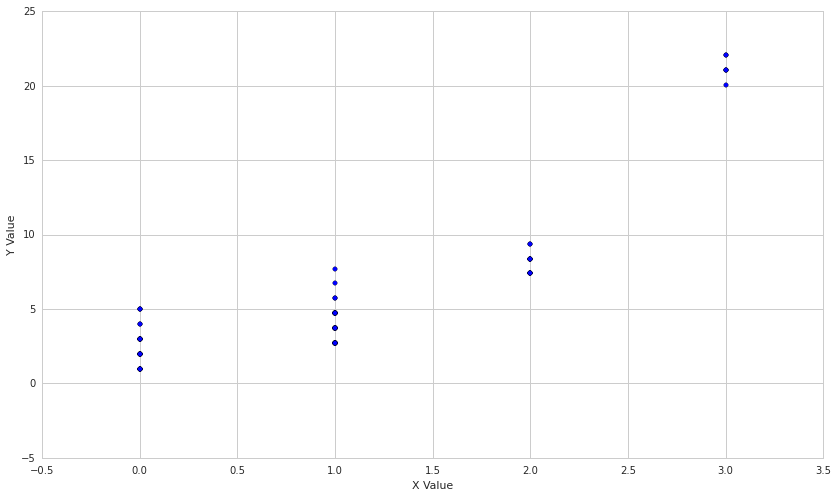

In [4]:
plt.scatter(X, Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

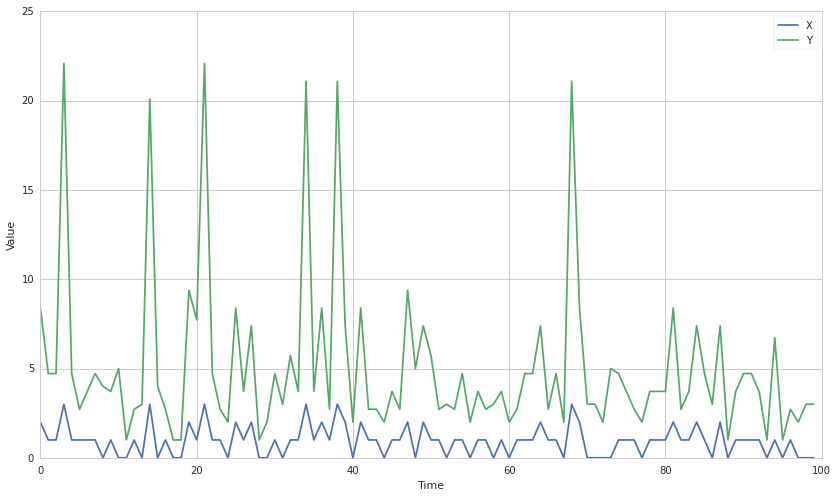

In [5]:
plt.plot(X)
plt.plot(Y)
plt.legend(['X', 'Y'])
plt.xlabel('Time')
plt.ylabel('Value')

Now let's see what happens if we add the delay.

In [6]:
n = 100

X = np.random.rand(n)
Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata([1,1] + list(X[:(n-2)]), method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
print r_s

0.134506450645


Sure enough, the relationship is not detected.

We can also use the `spearmanr` function in the `scipy.stats` library:

In [7]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X, Y)
print 'Spearman Rank Coefficient: ', r_s[0]
print 'p-value: ', r_s[1]

Spearman Rank Coefficient:  0.236363636364
p-value:  0.510885317515


We now have ourselves an $r_S$, but how do we interpret it? It's positive, so we know that the variables are not anticorrelated. It's not very large, so we know they aren't perfectly positively correlated, but it's hard to say from a glance just how significant the correlation is. Luckily, `spearmanr` also computes the p-value for this coefficient and sample size for us. We can see that the p-value here is above 0.05; therefore, we cannot claim that $X$ and $Y$ are correlated.

Now that we've seen how Spearman rank correlation works, we'll quickly go through the process again with some real data. For instance, we may wonder whether the expense ratio of a mutual fund is indicative of its three-year Sharpe ratio. That is, does spending more money on administration, management, etc. lower the risk or increase the returns? Quantopian does not currently support mutual funds, so we will pull the data from Yahoo Finance.

Spearman Rank Coefficient:  -0.369696969697
p-value:  0.293050075293


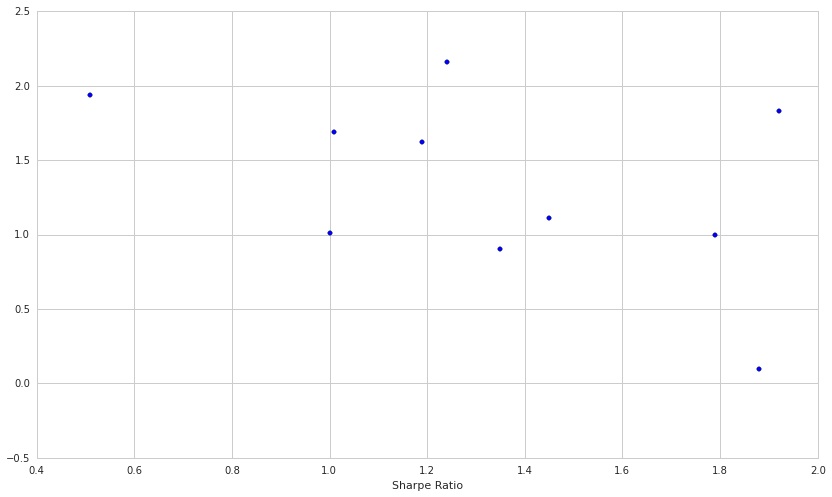

In [8]:
# Copying data for DXHLX, UGPIX, ALQIX, IIRFX, TMSCX, FHKCX, MCDFX, NRICX, PINHX, ANGLX
expense = [1.35, 1.79, 1.45, 1.88, 1., 1.01, 1.19, 1.92, 0.51, 1.24]
sharpe = [0.9, 1., 1.11, 0.1, 1.01, 1.69, 1.62, 1.83, 1.94, 2.16]

plt.scatter(expense, sharpe)
plt.xlabel('Expense Ratio')
plt.xlabel('Sharpe Ratio')

r_S = stats.spearmanr(expense, sharpe)
print 'Spearman Rank Coefficient: ', r_S[0]
print 'p-value: ', r_S[1]

It looks as though the expense ratio and Sharpe ratio may in fact be anticorrelated. But, we don't consider any of this meaningful as the p-value is above 0.05.

## Real World Use Case: Evaluating a Ranking Model

Let's say that we have some way of ranking securities and that we'd like to test how well our ranking performs in practice. In this case our model just takes the mean daily return for the last month and ranks the stocks by that metric. 

We hypothesize that this will be predictive of the mean returns over the next month. To test this we score the stocks based on a lookback window, then take the spearman rank correlation of the score and the mean returns over the walk forward month.

Our Scores

Asset(24757 [A])      -0.000624
Asset(2 [AA])         -0.003646
Asset(47842 [AAC])     0.002745
Asset(45971 [AAL])     0.005677
Asset(45415 [AAMC])   -0.020459
Asset(21 [AAME])       0.002207
Asset(523 [AAN])       0.003765
Asset(45503 [AAOI])    0.004758
Asset(9681 [AAON])     0.004228
Asset(23175 [AAP])     0.003887
Asset(24 [AAPL])      -0.001870
Asset(40707 [AAT])     0.001433
Asset(27922 [AAU])    -0.000576
Asset(27884 [AAV])     0.003966
Asset(47422 [AAVL])    0.017364
Asset(28378 [AAWW])    0.004993
Asset(66 [AB])        -0.000934
Asset(39927 [ABAC])   -0.005923
Asset(31 [ABAX])       0.000679
Asset(22574 [ABB])    -0.002108
Asset(43694 [ABBV])   -0.002467
Asset(22954 [ABC])    -0.000335
Asset(11232 [ABCB])    0.002142
Asset(39052 [ABCD])   -0.000333
Asset(23176 [ABCO])    0.008131
Asset(47935 [ABCW])    0.002776
Asset(46877 [ABDC])   -0.000825
Asset(45840 [ABEV])    0.000035
Asset(24761 [ABG])     0.000830
Asset(45676 [ABGB])   -0.003712
dtype: float64


The Walk Fo

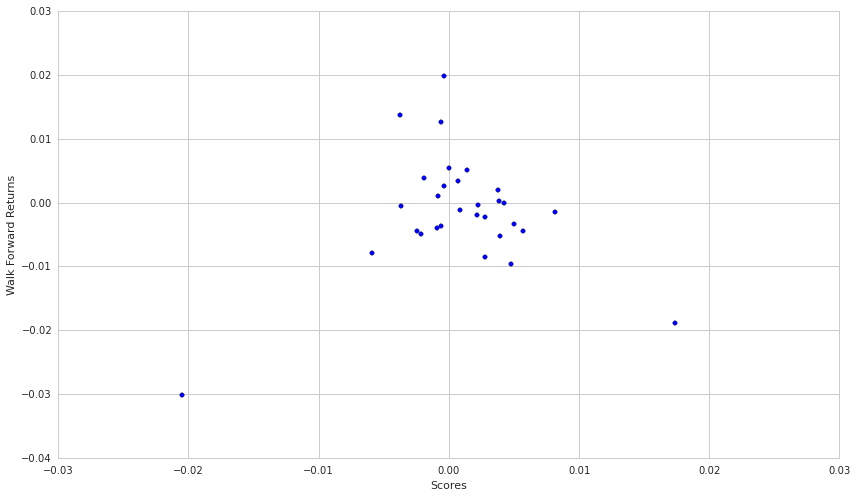

In [9]:
symbol_list = ['A', 'AA', 'AAC', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AB', 'ABAC', 'ABAX', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG', 'ABGB']

# Get the returns over the lookback window
start = '2014-12-01'
end = '2015-01-01'
historical_returns = get_pricing(symbol_list, fields='price', start_date=start, end_date=end).pct_change()[1:]

# Compute our stock score
scores = np.mean(historical_returns)
print 'Our Scores\n'
print scores
print '\n'

start = '2015-01-01'
end = '2015-02-01'
walk_forward_returns = get_pricing(symbol_list, fields='price', start_date=start, end_date=end).pct_change()[1:]
walk_forward_returns = np.mean(walk_forward_returns)
print 'The Walk Forward Returns\n'
print walk_forward_returns
print '\n'

plt.scatter(scores, walk_forward_returns)
plt.xlabel('Scores')
plt.ylabel('Walk Forward Returns')

r_s = stats.spearmanr(scores, walk_forward_returns)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

The p-value indicates that our hypothesis is false and we accept the null hypothesis that our ranking was no better than random. This is a really good check of any ranking system one devises for constructing a long-short equity portfolio.